# <center/>优化数据准备的性能

## 概述

数据是整个深度学习中最重要的一环，因为数据的好坏决定了最终结果的上限，模型的好坏只是去无限逼近这个上限，所以高质量的数据输入，会在整个深度神经网络中起到积极作用，数据在整个数据处理和数据增强的过程像经过pipeline管道的水一样，源源不断地流向训练系统，如图所示：

![title](https://gitee.com/mindspore/docs/raw/r1.1/tutorials/notebook/optimize_the_performance_of_data_preparation/images/pipeline.png)

MindSpore为用户提供了数据处理以及数据增强的功能，在数据的整个pipeline过程中，其中的每一步骤，如果都能够进行合理的运用，那么数据的性能会得到很大的优化和提升。本次体验将基于CIFAR-10数据集来为大家展示如何在数据加载、数据处理和数据增强的过程中进行性能的优化。

## 整体流程
- 准备环节。
- 数据加载性能优化。
- shuffle性能优化。
- 数据增强性能优化。
- 性能优化方案总结。

## 准备环节

### 导入模块

`dataset`模块提供API用来加载和处理数据集。

In [1]:
import mindspore.dataset as ds

`numpy`模块用于生成ndarray数组。

In [2]:
import numpy as np

### 下载所需数据集

运行以下命令来获取数据集：

In [3]:
! wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10.zip
! unzip -o cifar10.zip -d ./datasets
! tree ./datasets/cifar10

--2020-12-03 17:30:26--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 166235630 (159M) [application/zip]
Saving to: ‘cifar10.zip’

cifar10.zip         100%[===================>] 158.53M  58.1MB/s    in 2.7s    

2020-12-03 17:30:29 (58.1 MB/s) - ‘cifar10.zip’ saved [166235630/166235630]

Archive:  cifar10.zip
   creating: ./datasets/cifar10/
   creating: ./datasets/cifar10/test/
  inflating: ./datasets/cifar10/test/test_batch.bin  
   creating: ./datasets/cifar10/train/
  inflating: ./datasets/cifar10/train/batches.meta.txt  
  inflating: ./datasets/cifar10/train/data_batch_1.bin  
  inflating: ./datasets/cifar10/train/data_batch_2.bin  
  inflating: ./data

In [4]:
! wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10-py.zip
! unzip -o cifar10-py.zip -d ./datasets
! tree ./datasets/cifar-10-batches-py

--2020-12-03 17:30:32--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10-py.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 170647614 (163M) [application/zip]
Saving to: ‘cifar10-py.zip’

cifar10-py.zip      100%[===================>] 162.74M  62.0MB/s    in 2.6s    

2020-12-03 17:30:35 (62.0 MB/s) - ‘cifar10-py.zip’ saved [170647614/170647614]

Archive:  cifar10-py.zip
   creating: ./datasets/cifar-10-batches-py/
  inflating: ./datasets/cifar-10-batches-py/batches.meta  
  inflating: ./datasets/cifar-10-batches-py/data_batch_1  
  inflating: ./datasets/cifar-10-batches-py/data_batch_2  
  inflating: ./datasets/cifar-10-batches-py/data_batch_3  
  inflating: ./datasets/cifar-10-batches-py/data_batch_4  
  

## 数据加载性能优化

MindSpore为用户提供了多种数据加载方式，其中包括常用数据集加载、用户自定义数据集加载、MindSpore数据格式加载，详情内容请参考[加载数据集](https://www.mindspore.cn/doc/programming_guide/zh-CN/r1.1/dataset_loading.html)。对于数据集加载，底层实现方式的不同，会导致数据集加载的性能存在差异，如下所示：

|      | 常用数据集 | 用户自定义 | MindRecord |
| :----: | :----: | :----: | :----: |
| 底层实现 | C++ | Python | C++ |
| 性能 | 高 | 中 | 高|

### 性能优化方案

![title](https://gitee.com/mindspore/docs/raw/r1.1/tutorials/notebook/optimize_the_performance_of_data_preparation/images/data_loading_performance_scheme.png)

数据加载性能优化建议如下：
- 已经支持的数据集格式优选内置加载算子，具体内容请参考[内置加载算子](https://www.mindspore.cn/doc/api_python/zh-CN/r1.1/mindspore/mindspore.dataset.html)，如果性能仍无法满足需求，则可采取多线程并发方案，请参考本文[多线程优化方案](#多线程优化方案)。
- 不支持的数据集格式，优选转换为MindSpore数据格式后再使用`MindDataset`类进行加载，具体内容请参考[将数据集转换为MindSpore数据格式](https://www.mindspore.cn/tutorial/training/zh-CN/r1.1/advanced_use/convert_dataset.html)，如果性能仍无法满足需求，则可采取多线程并发方案，请参考本文[多线程优化方案](#多线程优化方案)。
- 不支持的数据集格式，算法快速验证场景，优选用户自定义`GeneratorDataset`类实现，如果性能仍无法满足需求，则可采取多进程并发方案，请参考本文[多进程优化方案](#多进程优化方案)。

### 代码示例

基于以上的数据加载性能优化建议，本次体验分别使用内置加载算子`Cifar10Dataset`类、数据转换后使用`MindDataset`类、使用`GeneratorDataset`类进行数据加载，代码演示如下：

1. 使用内置算子`Cifar10Dataset`类加载CIFAR-10数据集，这里使用的是CIFAR-10二进制格式的数据集，加载数据时采取多线程优化方案，开启了4个线程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [5]:
cifar10_path = "./datasets/cifar10/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[  7,   7,   6],
  [  4,   4,   3],
  [  4,   4,   4],
  ...
  [ 76,  69,  66],
  [ 78,  69,  66],
  [ 70,  65,  62]],
 [[  4,   4,   4],
  [  4,   4,   4],
  [  4,   4,   4],
  ...
  [ 84,  79,  69],
  [ 76,  69,  59],
  [ 59,  55,  48]],
 [[  4,   4,   4],
  [  4,   4,   4],
  [  4,   4,   4],
  ...
  [ 67,  60,  52],
  [ 55,  46,  39],
  [ 65,  62,  57]],
 ...
 [[ 94,  84,  81],
  [112, 105, 102],
  [111, 102,  95],
  ...
  [220, 220, 222],
  [225, 225, 226],
  [215, 215, 217]],
 [[ 93,  86,  81],
  [ 93,  83,  82],
  [107,  98,  95],
  ...
  [228, 228, 230],
  [239, 239, 240],
  [215, 215, 217]],
 [[139, 137, 137],
  [106, 101,  97],
  [ 89,  81,  78],
  ...
  [216, 216, 219],
  [216, 215, 218],
  [197, 196, 199]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 1)}


2. 使用`Cifar10ToMR`这个类将CIFAR-10数据集转换为MindSpore数据格式，这里使用的是CIFAR-10 python文件格式的数据集，然后使用`MindDataset`类加载MindSpore数据格式数据集，加载数据采取多线程优化方案，开启了4个线程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [6]:
from mindspore.mindrecord import Cifar10ToMR
import os

trans_path = "./transform/"
if not os.path.exists(trans_path):
    os.mkdir(trans_path)
os.system("rm -f {}cifar10*".format(trans_path))
cifar10_path = './datasets/cifar-10-batches-py'
cifar10_mindrecord_path = './transform/cifar10.record'

cifar10_transformer = Cifar10ToMR(cifar10_path,cifar10_mindrecord_path)
# executes transformation from Cifar10 to MindRecord
cifar10_transformer.transform(['label'])

# create MindDataset for reading data
cifar10_mind_dataset = ds.MindDataset(dataset_file=cifar10_mindrecord_path,num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_mind_dataset.create_dict_iterator()))

{'data': Tensor(shape=[1280], dtype=UInt8, value= [255, 216, 255, 224,   0,  16,  74,  70,  73,  70,   0,   1,   1,   0,   0,   1,   0,   1,   0,   0, 255, 219,   0,  67, 
   0,   2,   1,   1,   1,   1,   1,   2,   1,   1,   1,   2,   2,   2,   2,   2,   4,   3,   2,   2,   2,   2,   5,   4, 
   4,   3,   4,   6,   5,   6,   6,   6,   5,   6,   6,   6,   7,   9,   8,   6,   7,   9,   7,   6,   6,   8,  11,   8, 
   9,  10,  10,  10,  10,  10,   6,   8,  11,  12,  11,  10,  12,   9,  10,  10,  10, 255, 219,   0,  67,   1,   2,   2, 
   2,   2,   2,   2,   5,   3,   3,   5,  10,   7,   6,   7,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10, 
  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10, 
  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10, 255, 192,   0,  17,   8,   0,  32,   0,  32,   3, 
   1,  34,   0,   2,  17,   1,   3,  17,   1, 255, 196,   0,  31,   0,   0,   1,   5,   1,   1, 

3. 使用`GeneratorDataset`类加载自定义数据集，并且采取多进程优化方案，开启了4个进程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [7]:
def generator_func(num):
    for i in range(num):
        yield (np.array([i]),)

# create GeneratorDataset for reading data
dataset = ds.GeneratorDataset(source=generator_func(5),column_names=["data"],num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(dataset.create_dict_iterator()))

{'data': Tensor(shape=[1], dtype=Int64, value= [0])}


## shuffle性能优化

shuffle操作主要是对有序的数据集或者进行过repeat的数据集进行混洗，MindSpore专门为用户提供了`shuffle`函数，其中设定的`buffer_size`参数越大，混洗程度越大，但时间、计算资源消耗也会大。该接口支持用户在整个pipeline的任何时候都可以对数据进行混洗，具体内容请参考[shuffle处理](https://www.mindspore.cn/doc/programming_guide/zh-CN/r1.1/pipeline.html#shuffle)。但是因为底层的实现方式不同，该方式的性能不如直接在[内置加载算子](https://www.mindspore.cn/doc/api_python/zh-CN/r1.1/mindspore/mindspore.dataset.html)中设置`shuffle`参数直接对数据进行混洗。

### 性能优化方案

![title](https://gitee.com/mindspore/docs/raw/r1.1/tutorials/notebook/optimize_the_performance_of_data_preparation/images/shuffle_performance_scheme.png)

shuffle性能优化建议如下：
- 直接使用内置加载算子的`shuffle`参数进行数据的混洗。
- 如果使用的是`shuffle`函数，当性能仍无法满足需求，可通过调大`buffer_size`参数的值来优化提升性能。

### 代码示例

基于以上的shuffle性能优化建议，本次体验分别使用内置加载算子`Cifar10Dataset`类的`shuffle`参数和`Shuffle`函数进行数据的混洗，代码演示如下：

1. 使用内置算子`Cifar10Dataset`类加载CIFAR-10数据集，这里使用的是CIFAR-10二进制格式的数据集，并且设置`shuffle`参数为True来进行数据混洗，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [8]:
cifar10_path = "./datasets/cifar10/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,shuffle=True)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[ 17,  18,  27],
  [ 21,  25,  27],
  [ 36,  39,  29],
  ...
  [ 32,  34,  30],
  [ 34,  38,  25],
  [135, 142, 140]],
 [[  4,   5,   9],
  [ 19,  21,  21],
  [ 63,  60,  49],
  ...
  [ 10,  11,   9],
  [ 22,  25,  12],
  [ 80,  89,  76]],
 [[  4,   3,   7],
  [  6,  12,   5],
  [ 53,  53,  45],
  ...
  [  2,   6,   5],
  [  5,  11,   4],
  [ 18,  28,  17]],
 ...
 [[ 23,  37,  11],
  [ 35,  47,  20],
  [ 33,  45,  18],
  ...
  [ 54,  61,  20],
  [ 61,  66,  26],
  [ 61,  64,  26]],
 [[ 31,  43,  10],
  [ 35,  47,  16],
  [ 42,  54,  17],
  ...
  [ 50,  57,  23],
  [ 49,  55,  21],
  [ 54,  57,  23]],
 [[ 40,  43,  13],
  [ 41,  43,  19],
  [ 46,  47,  15],
  ...
  [ 63,  65,  25],
  [ 60,  63,  22],
  [ 56,  61,  18]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 7)}


2. 使用`shuffle`函数进行数据混洗，参数`buffer_size`设置为3，数据采用`GeneratorDataset`类自定义生成。

In [9]:
def generator_func():
    for i in range(5):
        yield (np.array([i,i+1,i+2,i+3,i+4]),)

ds1 = ds.GeneratorDataset(source=generator_func,column_names=["data"])
print("before shuffle:")
for data in ds1.create_dict_iterator():
    print(data["data"])

ds2 = ds1.shuffle(buffer_size=3)
print("after shuffle:")
for data in ds2.create_dict_iterator():
    print(data["data"])

before shuffle:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after shuffle:
[2 3 4 5 6]
[0 1 2 3 4]
[1 2 3 4 5]
[3 4 5 6 7]
[4 5 6 7 8]


## 数据增强性能优化

在图片分类的训练中，尤其是当数据集比较小的时候，用户可以使用数据增强的方式来预处理图片，从而丰富数据集。MindSpore为用户提供了多种数据增强的方式，其中包括：
- 使用内置C算子（`c_transforms`模块）进行数据增强。
- 使用内置Python算子（`py_transforms`模块）进行数据增强。
- 用户可根据自己的需求，自定义Python函数进行数据增强。

具体的内容请参考[数据增强](https://www.mindspore.cn/doc/programming_guide/zh-CN/r1.1/augmentation.html)。因为底层的实现方式不同，所以性能还是有一定的差异，如下所示：

|   模块   | 底层接口 | 说明 |
| :----: | :----: | :----: |
| c_transforms | C++（基于OpenCV）| 性能高 |
| py_transforms | Python（基于PIL） | 该模块提供了多种图像增强功能，并提供了PIL Image和Numpy数组之间的传输方法 |


### 性能优化方案

![title](https://gitee.com/mindspore/docs/raw/r1.1/tutorials/notebook/optimize_the_performance_of_data_preparation/images/data_enhancement_performance_scheme.png)


数据增强性能优化建议如下：
- 优先使用`c_transforms`模块进行数据增强，因为性能最高，如果性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)、[Compose优化方案](#Compose优化方案)或者[算子融合优化方案](#算子融合优化方案)。
- 如果使用了`py_transforms`模块进行数据增强，当性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)、[多进程优化方案](#多进程优化方案)、[Compose优化方案](#Compose优化方案)或者[算子融合优化方案](#算子融合优化方案)。
- `c_transforms`模块是在C++内维护buffer管理，`py_transforms`模块是在Python内维护buffer管理。因为Python和C++切换的性能成本，建议不要混用算子。
- 如果用户使用了自定义Python函数进行数据增强，当性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)或者[多进程优化方案](#多进程优化方案)，如果还是无法提升性能，就需要对自定义的Python代码进行优化。

### 代码示例

基于以上的数据增强性能优化建议，本次体验分别使用`c_transforms`模块和自定义Python函数进行了数据增强，演示代码如下所示：

1. 使用`c_transforms`模块进行数据增强，数据增强时采用多线程优化方案，开启了4个线程并发完成任务，并且采用了算子融合优化方案，使用`RandomResizedCrop`融合类替代`RandomResize`类和`RandomCrop`类。

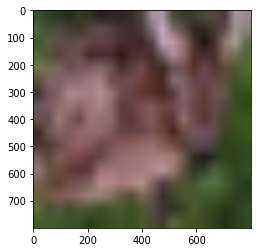

In [10]:
import mindspore.dataset.transforms.c_transforms as c_transforms
import mindspore.dataset.vision.c_transforms as C
import matplotlib.pyplot as plt
cifar10_path = "./datasets/cifar10/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,num_parallel_workers=4)
transforms = C.RandomResizedCrop((800,800))
# apply the transform to the dataset through dataset.map()
cifar10_dataset = cifar10_dataset.map(operations=transforms,input_columns="image",num_parallel_workers=4)

data = next(cifar10_dataset.create_dict_iterator())
plt.imshow(data["image"].asnumpy())
plt.show()

2. 使用自定义Python函数进行数据增强，数据增强时采用多进程优化方案，开启了4个进程并发完成任务。

In [11]:
def generator_func():
    for i in range(5):
        yield (np.array([i,i+1,i+2,i+3,i+4]),)

ds3 = ds.GeneratorDataset(source=generator_func,column_names=["data"])
print("before map:")
for data in ds3.create_dict_iterator():
    print(data["data"])

func = lambda x:x**2
ds4 = ds3.map(operations=func,input_columns="data",python_multiprocessing=True,num_parallel_workers=4)
print("after map:")
for data in ds4.create_dict_iterator():
    print(data["data"])

before map:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after map:
[ 0  1  4  9 16]
[ 1  4  9 16 25]
[ 4  9 16 25 36]
[ 9 16 25 36 49]
[16 25 36 49 64]


## 性能优化方案总结

### 多线程优化方案

在数据pipeline过程中，相关算子一般都有线程数设置参数，来提升处理并发度，提升性能，例如：
- 在数据加载的过程中，内置数据加载类有`num_parallel_workers`参数用来设置线程数。
- 在数据增强的过程中，`map`函数有`num_parallel_workers`参数用来设置线程数。
- 在Batch的过程中，`batch`函数有`num_parallel_workers`参数用来设置线程数。

具体内容请参考[内置加载算子](https://www.mindspore.cn/doc/api_python/zh-CN/r1.1/mindspore/mindspore.dataset.html)。

### 多进程优化方案

数据处理中Python实现的算子均支持多进程的模式，例如：
- `GeneratorDataset`这个类默认是多进程模式，它的`num_parallel_workers`参数表示的是开启的进程数，默认为1，具体内容请参考[GeneratorDataset](https://www.mindspore.cn/doc/api_python/zh-CN/r1.1/mindspore/dataset/mindspore.dataset.GeneratorDataset.html)。
- 如果使用Python自定义函数或者`py_transforms`模块进行数据增强的时候，当`map`函数的参数`python_multiprocessing`设置为True时，此时参数`num_parallel_workers`表示的是进程数，参数`python_multiprocessing`默认为False，此时参数`num_parallel_workers`表示的是线程数，具体的内容请参考[内置加载算子](https://www.mindspore.cn/doc/api_python/zh-CN/r1.1/mindspore/mindspore.dataset.html)。

### Compose优化方案

Map算子可以接收Tensor算子列表，并将按照顺序应用所有的这些算子，与为每个Tensor算子使用的Map算子相比，此类“胖Map算子”可以获得更好的性能，如图所示：

![title](https://gitee.com/mindspore/docs/raw/r1.1/tutorials/notebook/optimize_the_performance_of_data_preparation/images/compose.png)

### 算子融合优化方案

提供某些融合算子，这些算子将两个或多个算子的功能聚合到一个算子中。具体内容请参考[数据增强算子](https://www.mindspore.cn/doc/api_python/zh-CN/r1.1/mindspore/mindspore.dataset.vision.html)，与它们各自组件的流水线相比，这种融合算子提供了更好的性能。如图所示：

![title](https://gitee.com/mindspore/docs/raw/r1.1/tutorials/notebook/optimize_the_performance_of_data_preparation/images/operator_fusion.png)